In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd

In [3]:
# import libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point, Polygon

In [4]:
df = pd.read_csv("crime_data_cleaned_2006_to_2021.csv", index_col=0)
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

/Users/zeqi.w/anaconda3/envs/py_env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df.shape

(7653281, 7)

In [6]:
# import street map
street_map = gpd.read_file('geo_export_8d2f8abd-a496-4660-bc87-d1d5859eba32.shp')

# designate coordinate system
crs = {'init':'epsg:4326'}
# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

/Users/zeqi.w/anaconda3/envs/py_env/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


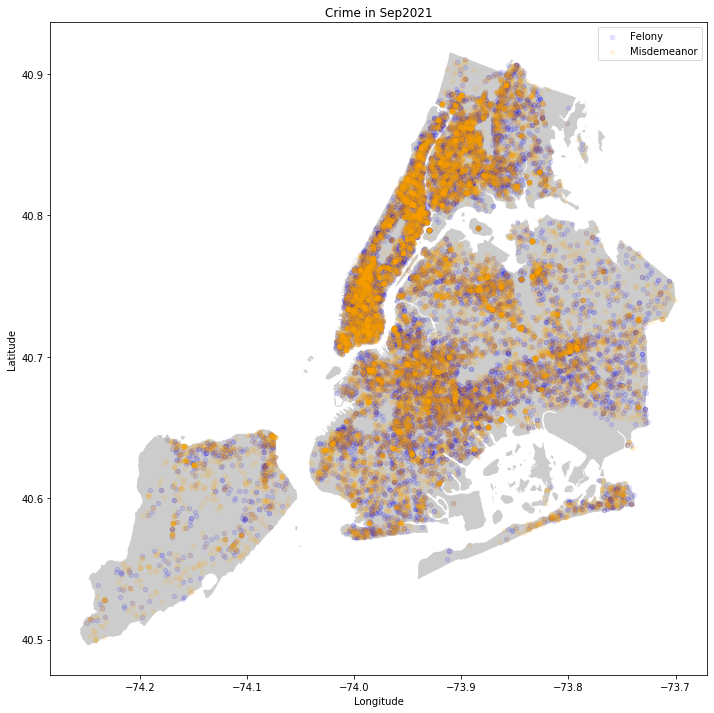

In [7]:
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)

fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax = ax, alpha=0.4, color='grey');
geo_df[(geo_df['Level_of_offense'] == 'FELONY')&(geo_df['Date'] >= '2021-09-01')].plot(ax=ax, markersize=20, alpha=0.1, color='blue', marker='o', label='Felony')
geo_df[(geo_df['Level_of_offense'] == 'MISDEMEANOR')&(geo_df['Date'] >= '2021-09-01')].plot(ax=ax, markersize=20, alpha=0.1, color='orange', marker='o', label='Misdemeanor')
# geo_df[(geo_df['Level_of_offense'] == 'Violation')&(geo_df['Date'] >= '2021-09-01')].plot(ax=ax, markersize=20, alpha=0.1, color='blue', marker='o', label='Violation')
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Crime in Sep2021");

In [8]:
geo_df.head()

Date      Time Level_of_offense   Latitude  Longitude  Year  Month  \
0 2021-09-29  12:50:00           FELONY  40.853507 -73.882203  2021      9   
1 2021-09-16  05:15:00           FELONY  40.696329 -73.937711  2021      9   
2 2021-09-15  01:13:00           FELONY  40.805364 -73.937663  2021      9   
3 2021-09-07  19:35:00           FELONY  40.892351 -73.856440  2021      9   
4 2021-09-03  20:35:00           FELONY  40.887303 -73.845167  2021      9   

                     geometry  
0  POINT (-73.88220 40.85351)  
1  POINT (-73.93771 40.69633)  
2  POINT (-73.93766 40.80536)  
3  POINT (-73.85644 40.89235)  
4  POINT (-73.84517 40.88730)

In [9]:
geo_df.shape

(7653281, 8)

In [10]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time

In [11]:
df.columns

Index(['Date', 'Time', 'Level_of_offense', 'Latitude', 'Longitude', 'Year',
       'Month', 'geometry'],
      dtype='object')

In [12]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

##reference: https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/

def dbscan_reduce(df, epsilon, x='Longitude', y='Latitude'):
    start_time = time.time()
    # represent points consistently as (lat, lon) and convert to radians to fit using haversine metric
    coords = df[[y, x]].values    
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    print('Number of clusters: {:,}'.format(num_clusters))
    
    clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])
    
    # find the point in each cluster that is closest to its centroid
    centermost_points = clusters.map(get_centermost_point)

    # unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
    lats, lons = zip(*centermost_points)
    rep_points = pd.DataFrame({x:lons, y:lats})
    rep_points.tail()
    
    # pull row from original data set where lat/lon match the lat/lon of each row of representative points
    rs = rep_points.apply(lambda row: df[(df[y]==row[y]) & (df[x]==row[x])].iloc[0], axis=1)
    
    # all done, print outcome
    message = 'Clustered {:,} points down to {:,} points, for {:.2f}% compression in {:,.2f} seconds.'
    print(message.format(len(df), len(rs), 100*(1 - float(len(rs)) / len(df)), time.time()-start_time))    
    return rs

In [13]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [14]:
df_ = df.loc[df['Date']>='2021-09-01'].copy()

In [15]:
# first cluster the full gps location history data set coarsely, with epsilon=5km in radians
eps_rad = 0.1 / kms_per_radian
df_clustered = dbscan_reduce(df_, epsilon=eps_rad)

Number of clusters: 8,272
Clustered 36,569 points down to 8,272 points, for 77.38% compression in 13.91 seconds.


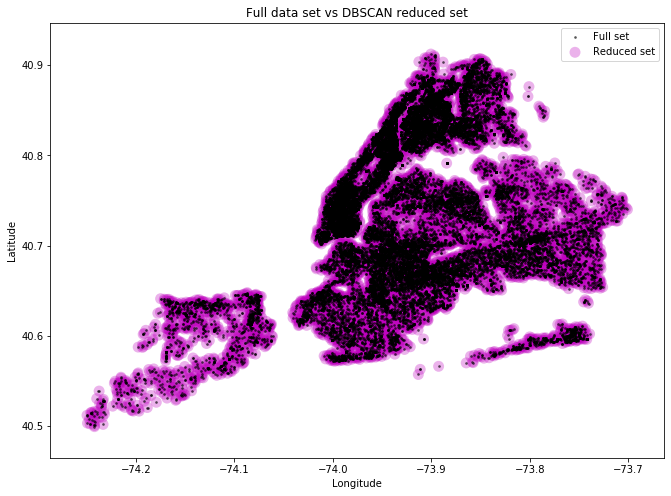

In [16]:
# show a map of the worldwide data points
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_clustered['Longitude'], df_clustered['Latitude'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(df_['Longitude'], df_['Latitude'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

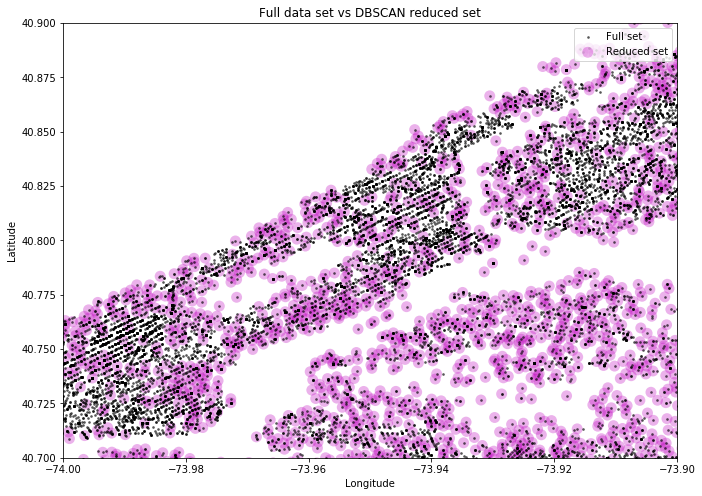

In [17]:
# show a map of only the california data points
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_clustered['Longitude'], df_clustered['Latitude'], c='m', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(df_['Longitude'], df_['Latitude'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim([-74, -73.9])
ax.set_ylim([40.7, 40.9])
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

In [18]:
df_clustered

Date      Time Level_of_offense   Latitude  Longitude  Year  Month  \
0    2021-09-27  22:25:00        VIOLATION  40.854153 -73.886037  2021      9   
1    2021-09-23  07:39:00      MISDEMEANOR  40.698302 -73.937583  2021      9   
2    2021-09-18  17:35:00      MISDEMEANOR  40.801875 -73.941354  2021      9   
3    2021-09-04  10:00:00        VIOLATION  40.890992 -73.858714  2021      9   
4    2021-09-03  20:35:00           FELONY  40.887303 -73.845167  2021      9   
...         ...       ...              ...        ...        ...   ...    ...   
8267 2021-09-05  14:30:00           FELONY  40.692322 -73.812199  2021      9   
8268 2021-09-02  08:00:00           FELONY  40.713025 -73.773176  2021      9   
8269 2021-09-01  22:30:00           FELONY  40.716004 -73.912730  2021      9   
8270 2021-09-02  23:35:00        VIOLATION  40.745196 -73.927784  2021      9   
8271 2021-09-03  11:30:00        VIOLATION  40.605130 -74.126761  2021      9   

                                          geometry  
0     POINT (-73.88603727099995 40.85415307500005)  
1     POINT (-73.93758254599999 40.69830236900003)  
2          POINT (-73.941353855 40.80187468900005)  
3     POINT (-73.85871415599996 40.89099236700008)  
4           POINT (-73.84516691 40.88730259600004)  
...                                            ...  
8267  POINT (-73.81219887099995 40.69232245200004)  
8268  POINT (-73.77317591899998 40.71302461400006)  
8269  POINT (-73.91272957099994 40.71600367000008)  
8270  POINT (-73.92778375599994 40.74519635000007)  
8271  POINT (-74.12676102599994 40.60512989200004)  

[8272 rows x 8 columns]

In [20]:
df_felony = df.loc[(df['Date']>='2021-09-01')&(df['Level_of_offense']=='FELONY')].copy()
df_misdemeanor = df.loc[(df['Date']>='2021-09-01')&(df['Level_of_offense']=='MISDEMEANOR')].copy()
df_violation = df.loc[(df['Date']>='2021-09-01')&(df['Level_of_offense']=='VIOLATION')].copy()

Number of clusters: 1,870
Clustered 11,855 points down to 1,870 points, for 84.23% compression in 3.16 seconds.
Number of clusters: 1,938
Clustered 18,321 points down to 1,938 points, for 89.42% compression in 3.75 seconds.
Number of clusters: 1,932
Clustered 6,393 points down to 1,932 points, for 69.78% compression in 2.84 seconds.


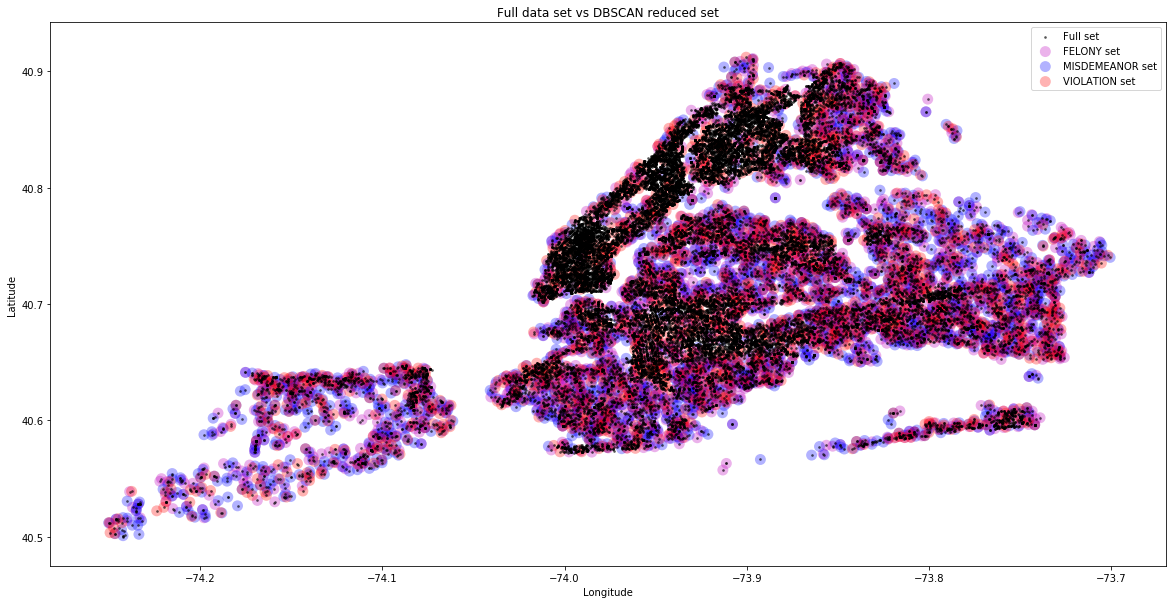

In [21]:
# first cluster the full gps location history data set coarsely, with epsilon=5km in radians
eps_rad = 0.2 / kms_per_radian
df_felony_ = dbscan_reduce(df_felony, epsilon=eps_rad)
df_misdemeanor_ = dbscan_reduce(df_misdemeanor, epsilon=eps_rad)
df_violation_ = dbscan_reduce(df_violation, epsilon=eps_rad)

# show a map of the worldwide data points
fig, ax = plt.subplots(figsize=[20, 10])
rs_scatter_felony = ax.scatter(df_felony_['Longitude'], df_felony_['Latitude'], c='m', edgecolor='None', alpha=0.3, s=120)
rs_scatter_misdemeanor = ax.scatter(df_misdemeanor_['Longitude'], df_misdemeanor_['Latitude'], c='b', edgecolor='None', alpha=0.3, s=120)
rs_scatter_violation = ax.scatter(df_violation_['Longitude'], df_violation_['Latitude'], c='r', edgecolor='None', alpha=0.3, s=120)

df_scatter = ax.scatter(df_['Longitude'], df_['Latitude'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter_felony, rs_scatter_misdemeanor, rs_scatter_violation], ['Full set', 'FELONY set', 'MISDEMEANOR set', 'VIOLATION set'], loc='upper right')
plt.show()

In [22]:
df_felony_

Date      Time Level_of_offense   Latitude  Longitude  Year  Month  \
0    2021-09-13  15:00:00           FELONY  40.838025 -73.904510  2021      9   
1    2021-09-03  02:50:00           FELONY  40.697737 -73.928571  2021      9   
2    2021-09-26  15:34:00           FELONY  40.767038 -73.968901  2021      9   
3    2021-09-19  15:15:00           FELONY  40.888875 -73.859883  2021      9   
4    2021-09-11  01:00:00           FELONY  40.886803 -73.846871  2021      9   
...         ...       ...              ...        ...        ...   ...    ...   
1865 2021-09-03  22:35:00           FELONY  40.649215 -73.929098  2021      9   
1866 2021-09-03  15:50:00           FELONY  40.640661 -74.095545  2021      9   
1867 2021-09-01  10:30:00           FELONY  40.724515 -73.855373  2021      9   
1868 2021-09-02  13:00:00           FELONY  40.908445 -73.903675  2021      9   
1869 2021-09-01  22:30:00           FELONY  40.716004 -73.912730  2021      9   

                                          geometry  
0     POINT (-73.90451043399997 40.83802547000005)  
1     POINT (-73.92857085299994 40.69773719600005)  
2     POINT (-73.96890058499997 40.76703826500005)  
3     POINT (-73.85988323499998 40.88887489200005)  
4     POINT (-73.84687148999996 40.88680259100005)  
...                                            ...  
1865  POINT (-73.92909848799998 40.64921535900004)  
1866  POINT (-74.09554512199999 40.64066123700008)  
1867  POINT (-73.85537272199997 40.72451505500004)  
1868  POINT (-73.90367484699993 40.90844541100006)  
1869  POINT (-73.91272957099994 40.71600367000008)  

[1870 rows x 8 columns]

In [23]:
df_felony_.iloc[:,:-3].to_csv("df_felony.csv")
df_misdemeanor_.iloc[:,:-3].to_csv("df_misdemeanor.csv")
df_violation_.iloc[:,:-3].to_csv("df_violation.csv")


df_felony_.iloc[:,:-3].to_json("df_felony.json", orient='records')
df_misdemeanor_.iloc[:,:-3].to_json("df_misdemeanor.json", orient='records')
df_violation_.iloc[:,:-3].to_json("df_violation.json", orient='records')

In [24]:
df_felony_.shape

(1870, 8)

In [25]:
df_misdemeanor_.shape

(1938, 8)

In [26]:
df_violation_.shape

(1932, 8)

In [22]:
# show a map of only the california data points
fig, ax = plt.subplots(figsize=[20, 10])
rs_scatter_felony = ax.scatter(df_felony_['Longitude'], df_felony_['Latitude'], c='m', edgecolor='None', alpha=0.3, s=120)
rs_scatter_misdemeanor = ax.scatter(df_misdemeanor_['Longitude'], df_misdemeanor_['Latitude'], c='b', edgecolor='None', alpha=0.3, s=120)
rs_scatter_violation = ax.scatter(df_violation_['Longitude'], df_violation_['Latitude'], c='r', edgecolor='None', alpha=0.3, s=120)
df_scatter = ax.scatter(df_['Longitude'], df_['Latitude'], c='k', alpha=0.5, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim([-74, -73.9])
ax.set_ylim([40.7, 40.9])
ax.legend([df_scatter, rs_scatter_felony, rs_scatter_misdemeanor, rs_scatter_violation], ['Full set', 'FELONY set', 'MISDEMEANOR set', 'VIOLATION set'], loc='upper right')
plt.show()